In [1]:
from typing import Dict, List, Tuple
from dataclasses import dataclass
from radcad import Model, Simulation

import pandas as pd
import matplotlib.pyplot as plt
import random
from dataclasses import asdict

In [2]:
import sys
sys.path.append("../")
from utils.plot_utils import plot_results
from utils.data_format_utils import prep_results

In [3]:
from model.lend_policy import lend_policy, _generate_borrower_list
from model.save_policy import save_policy, _generate_saver_list
from model.state_update import (su_btc_pool, 
                                su_lend_module, 
                                su_rune_supply_tracker,
                                su_thor_usd_pool,
                                su_thor_usd_vault,
                                 su_btc_pool,
                                su_thor_btc_vault
                               )

In [4]:
from model.model_data_classes import (
                                Pool,
                                RuneSupply,
                                LendModule,
                                ThorUsdVault,
                                LpPosition,
                                SavingsVault
                            )

# Steady-State Model
Companion Notebook for Steady-State Analysis: 
https://lively-router-cb2.notion.site/PUBLIC-Steady-State-Model-99bcf7388bda4c13a60d21c59adc3983

## Assumptions
1. price constant - rune, asset
1. Fraction of Pool as collateral: Up to 20%
1. Fraction of Derived assets in Savings Vaults: 80%
1. Levels of participation - Savings, lending are roughly balanced.
1. Savings yield: is still desirable to 6%
1. CR: is desirable to 250%

**Research Question:** How does Rune Inflation behave in the inital blocks of the steady-state scenario? 

**Context:** Devs want to understand the impact of rune inflation during the inital launch of ThorFi (borrow, save). 

## Constants


In [5]:
# Pool Amplification Factor to tweak mint/redeem fees (down to force higher fees)
POOL_AMP_FACTOR = 0.999
# Saver Block Reward Frequency to tweak USD Saver yield (down to force higher yield)
# Maximum CR users are willing take loan for.
MAX_DESIREABLE_CR = 2.5 # 2.5 = 250%
# Loan MaxCR to tweak attracting all lenders (down to get more lenders)
MAX_CR = 3.0 # in percent, 3 = 300%
MIN_CR = 1.0
SAVINGS_VAULT_UTILIZATION = 80.0 # 80% of derived assets are locked in vault.
MIN_DESIREABLE_SAVINGS_APY = 6.0 # 6 percent

RUNE_PRICE_USD = 7.0
BTC_PRICE_USD = 40000.0
# Set seed for reproducibility
random.seed(42)

# Initial State


In [6]:
# btc LP pool values
btc_pool = Pool(pool_asset_depth=875.0,
                pool_rune_depth=5000000,
                pool_asset_collateral = 0,  #875.0 * 0.2, 
                pool_rune_collateral= 0, #5000000 * 0.2,
                pool_yield=20.0, # percent
                asset_price_usd=BTC_PRICE_USD,
                pool_units=500246145359196,
                historic_slip=[0.0],
               )

# thor.usd virtual pool values
thor_usd_pool = Pool(pool_asset_depth=70000000, # THOR.USD in THOR.USD/RUNE pool
                pool_rune_depth=10000000, # RUNE in THOR.USD/RUNE pool
                pool_asset_collateral =0.0, 
                pool_rune_collateral=0.0,
                pool_yield=20.0, # percent
                asset_price_usd=RUNE_PRICE_USD,
                pool_units = 0, # virtual pools have no units
                historic_slip=[0.0]
               )

# lending module for btc
btc_lend_module =  LendModule(
        asset="BTC.BTC",
        debt_minted=0,
        debt_owed=0,
        latest_CR=MIN_CR,
        loans={} 
    )

btc_vault = SavingsVault(
            asset='THOR.BTC',
            deposits=0.0,
            withdrawals=0.0,
            APY=10, # 10%
            members = {}  # user key, initial deposit value
            )

# Amount of rune in the system
rune_supply_tracker = RuneSupply(
                        rune_supply=500_000_000,
                        rune_lend_inflation=0,
                        rune_save_deflation=0 
                    )

# vault balances
usd_vault = ThorUsdVault(
             fee_revenue=0.,
                deposits=0.,
                withdrawals=0.,
                APY=10,
             )

PARAMS = {}

INITIAL_STATE_DICT = {
    'btc_pool' : btc_pool, # state of the pool
    'thor_usd_pool' : thor_usd_pool,
    'thor_btc_vault': btc_vault,
    'lend_module' : btc_lend_module, #
    'rune_supply_tracker': rune_supply_tracker,#
    'thor_usd_vault': usd_vault,
}

## Config Partial-State Update Block

In [7]:
 state_update_blocks = [
    {
        'policies': {
            'lend_policy': lend_policy,
            #'save_policy': save_policy
        },
        # keys for State Update funcs
        'variables': {
            'btc_pool' : su_btc_pool, # state of the pool
            'thor_usd_pool' : su_thor_usd_pool,
            'lend_module' : su_lend_module, #
            'rune_supply_tracker': su_rune_supply_tracker,#
            'thor_usd_vault': su_thor_usd_vault,
            #'thor_btc_vault': su_thor_btc_vault,
            
    }
    },
    {
        'policies': {
            'save_policy': save_policy
        },
        # keys for State Update funcs
        'variables': {
            
            'btc_pool': su_btc_pool,
            'thor_btc_vault': su_thor_btc_vault,
            'thor_usd_vault': su_thor_usd_vault,
            #'thor_usd_pool': su_thor_usd_pool,
            'rune_supply_tracker': su_rune_supply_tracker,
            #'users': su_users_savings,
        }
    }
]

In [8]:
 combined_state_update_blocks = [
    {
        'policies': {
            'lend_policy': lend_policy,
            'save_policy': save_policy
        },
        # keys for State Update funcs
        'variables': {
            'btc_pool' : su_btc_pool, # state of the pool
            'thor_usd_pool' : su_thor_usd_pool,
            'lend_module' : su_lend_module, #
            'rune_supply_tracker': su_rune_supply_tracker,#
            'thor_usd_vault': su_thor_usd_vault,
            'thor_btc_vault': su_thor_btc_vault,
            
    }
    },
]

## system Params
`_params` use in policies 

In [9]:
 # Generate a list of LP positions to used as collateral
# in future, can make lp positions a stochastic process, draw from distribution.
borrower_list = _generate_borrower_list(1000)

In [10]:
borrower_list[10]

LpPosition(pool='BTC.BTC', lp_asset_amount=0.175, lp_rune_amount=1000, lp_units=77171162621)

In [11]:
saver_list = _generate_saver_list(1000)

In [12]:
saver_list[10]

LpPosition(pool='BTC.BTC', lp_asset_amount=0.175, lp_rune_amount=0, lp_units=0)

In [13]:
sys_params = {
    'pool_amp_factor': [POOL_AMP_FACTOR],
    'max_CR': [MAX_CR],
    'min_cr': [MIN_CR], # Not currently used, hard coded at 1 (100%)
    'max_desirable_CR': [MAX_DESIREABLE_CR],
    'borrower': [borrower_list],# list of LP dataclass objects
    'min_desireable_apy': [MIN_DESIREABLE_SAVINGS_APY], # min apy savers will still deposit for.
    'saver': [saver_list]
}

In [14]:
model = Model(
    # Model initial state
    initial_state=INITIAL_STATE_DICT,
    # Model Partial State Update Blocks
    state_update_blocks=combined_state_update_blocks,
    # System Parameters
    params=sys_params
)

simulation = Simulation(
    model=model,
    timesteps=1000,  # Number of timesteps
    runs=1  # Number of Monte Carlo Runs
)



## Run Model

In [15]:
raw_result = simulation.run()

/Users/nishanths/Documents/dev/cadcad/thorfi-sim/models/v0/notebooks/../utils/math_utils.py:24: RuntimeWarning: overflow encountered in double_scalars
  return (1 + block_yield) ** n_y - 1


## Inspect Results

In [16]:
results_dict = prep_results(raw_result=raw_result, asset_pool_col='btc_pool', vault_name_col='thor_btc_vault') 

In [17]:
# unpack the dataframes
result_df = results_dict['result']
pool_df = results_dict['pool_df']
loan_df = results_dict['loan_df']
vault_df = results_dict['vault_df']
deposits_df = results_dict['deposits_df']

In [18]:
result_df.head()

btc_pool  \
0  Pool(pool_asset_depth=875.0, pool_rune_depth=5...   
1  Pool(pool_asset_depth=875.0, pool_rune_depth=5...   
2  Pool(pool_asset_depth=875.0, pool_rune_depth=5...   
3  Pool(pool_asset_depth=875.0, pool_rune_depth=5...   
4  Pool(pool_asset_depth=875.0, pool_rune_depth=5...   

                                       thor_usd_pool  \
0  Pool(pool_asset_depth=70000000, pool_rune_dept...   
1  Pool(pool_asset_depth=70000000, pool_rune_dept...   
2  Pool(pool_asset_depth=70000000, pool_rune_dept...   
3  Pool(pool_asset_depth=70000000, pool_rune_dept...   
4  Pool(pool_asset_depth=70000000, pool_rune_dept...   

                                      thor_btc_vault  \
0  SavingsVault(asset='THOR.BTC', APY=10, deposit...   
1  SavingsVault(asset='THOR.BTC', APY=10, deposit...   
2  SavingsVault(asset='THOR.BTC', APY=10, deposit...   
3  SavingsVault(asset='THOR.BTC', APY=10, deposit...   
4  SavingsVault(asset='THOR.BTC', APY=10, deposit...   

                                         lend_module  \
0  LendModule(asset='BTC.BTC', debt_minted=0, deb...   
1  LendModule(asset='BTC.BTC', debt_minted=13974....   
2  LendModule(asset='BTC.BTC', debt_minted=27944....   
3  LendModule(asset='BTC.BTC', debt_minted=41907....   
4  LendModule(asset='BTC.BTC', debt_minted=55865....   

                                 rune_supply_tracker  \
0  RuneSupply(rune_supply=500000000, rune_lend_in...   
1  RuneSupply(rune_supply=500000999.99976027, run...   
2  RuneSupply(rune_supply=500001999.2004796, rune...   
3  RuneSupply(rune_supply=500002997.60279655, run...   
4  RuneSupply(rune_supply=500003995.20734876, run...   

                                      thor_usd_vault  simulation  subset  run  \
0  ThorUsdVault(APY=10, fee_revenue=0.0, deposits...           0       0    1   
1  ThorUsdVault(APY=0.0, fee_revenue=19.58265, de...           0       0    1   
2  ThorUsdVault(APY=inf, fee_revenue=39.155240000...           0       0    1   
3  ThorUsdVault(APY=inf, fee_revenue=58.717790000...           0       0    1   
4  ThorUsdVault(APY=inf, fee_revenue=78.2703, dep...           0       0    1   

   substep  timestep  
0        0         0  
1        1         1  
2        1         2  
3        1         3  
4        1         4

In [19]:
pool_df.head() 

pool_asset_depth  pool_rune_depth  pool_asset_collateral  \
0             875.0          5000000                  0.000   
1             875.0          5000000                  0.175   
2             875.0          5000000                  0.350   
3             875.0          5000000                  0.525   
4             875.0          5000000                  0.700   

   pool_rune_collateral       pool_units  pool_yield  asset_price_usd  \
0                     0  500246145359196        20.0          40000.0   
1                  1000  500246145359196        20.0          40000.0   
2                  2000  500246145359196        20.0          40000.0   
3                  3000  500246145359196        20.0          40000.0   
4                  4000  500246145359196        20.0          40000.0   

                           historic_slip  loan_collat_proportion  
0                                  [0.0]                  0.0000  
1                          [0.0, 0.0002]                  0.0002  
2                  [0.0, 0.0002, 0.0002]                  0.0004  
3          [0.0, 0.0002, 0.0002, 0.0002]                  0.0006  
4  [0.0, 0.0002, 0.0002, 0.0002, 0.0002]                  0.0008

In [20]:
loan_df.head() 

loan_id       user block   debt_minted     debt_owed collat_rune  \
0  user-USLM-0  user-USLM     0  13974.819586  13994.402239        1000   
1  user-BTHJ-1  user-BTHJ     1  13969.236358  13988.808953        1000   
2  user-NOLC-2  user-NOLC     2   13963.65759  13983.220136        1000   
3  user-YKFU-3  user-YKFU     3  13958.083276  13977.635783        1000   
4  user-HUIY-4  user-HUIY     4  13952.513411  13972.055888        1000   

  collat_asset collat_lp_units loan_cr  
0        0.175     77171162621  1.0004  
1        0.175     77171162621  1.0008  
2        0.175     77171162621  1.0012  
3        0.175     77171162621  1.0016  
4        0.175     77171162621   1.002

In [21]:
def _create_rune_supply_df(
        result_df: pd.DataFrame, 
    ) -> pd.DataFrame:

        supply_df = pd.DataFrame([asdict(x) for x in result_df['rune_supply_tracker'].to_list()])
        
        return supply_df

In [22]:
supply_df = _create_rune_supply_df(result_df)

In [23]:
supply_df.head(2)

rune_supply  rune_lend_inflation  rune_save_deflation
0  5.000000e+08              0.00000              0.00000
1  5.000010e+08           1999.20032            999.20056

In [24]:
supply_df['net_inflation'] = supply_df['rune_lend_inflation']  - supply_df['rune_save_deflation']

<AxesSubplot:>

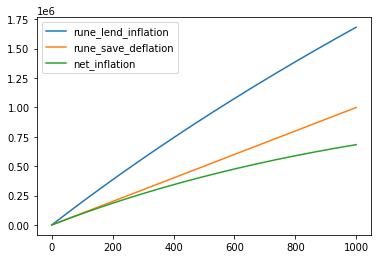

In [25]:
supply_df[['rune_lend_inflation', 'rune_save_deflation','net_inflation']].iloc[:3000].plot()

Calculate the percentage change in Rune Supply

In [26]:
pct_change = ((supply_df['rune_supply'].iloc[-1] - supply_df['rune_supply'].iloc[0]) / supply_df['rune_supply'].iloc[0]) * 100

print(f"Rune supply Change (%): {round(pct_change,3)}%")

Rune supply Change (%): 0.137%


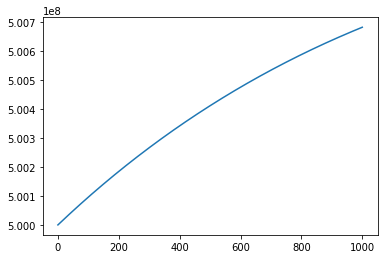

In [27]:
plt.plot(supply_df['rune_supply'])

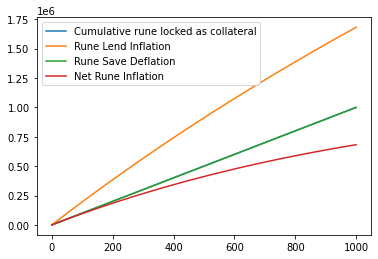

In [28]:
#plt.plot(supply_df['rune_supply'].iloc[:3000])
plt.plot(loan_df['collat_rune'].iloc[:3000].cumsum(), label='Cumulative rune locked as collateral')
plt.plot(supply_df['rune_lend_inflation'].iloc[:3000], label='Rune Lend Inflation')
plt.plot(supply_df['rune_save_deflation'].iloc[:3000], label='Rune Save Deflation')
plt.plot(supply_df['rune_lend_inflation'] - supply_df['rune_save_deflation'], label='Net Rune Inflation')
plt.legend()

## Plots

In [29]:
 %%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [30]:
plot_results(
    result_df=result_df,
    pool_df=pool_df,
    pool_name='BTC.BTC',
    loan_df=loan_df)